# Initialization

In [1]:
import numpy as np
import mglearn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import ScalarFormatter
from matplotlib import gridspec
import matplotlib.axes
import pandas as pd
import datetime
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.cluster import AgglomerativeClustering
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

In [15]:
# Load only relevant columns from the meta data set csv
df = pd.read_csv('cambium_Mid_Case_2030_p80.csv', usecols=['timestamp_local','total_price','co2_rate_marginal'])
# Creates two new columns for date and time, respectively
df['Month'] = pd.DatetimeIndex(df['timestamp_local']).month
df['Dates'] = pd.to_datetime(df['timestamp_local']).dt.date
df['day'] = pd.DatetimeIndex(df['timestamp_local']).day
df['hour'] = pd.DatetimeIndex(df['timestamp_local']).hour
df['Time'] = pd.to_datetime(df['timestamp_local']).dt.time
df = df.set_index("Dates")

shortdf = df.loc[df['total_price'] > 150]
shortidx = shortdf.index
shortdf = df.drop(shortidx)
shortdf = shortdf.loc[shortdf['Month'] == 7]
shortdf = shortdf.drop(columns = ['Month'])

# shortdf.head(168)

dfp = shortdf[['timestamp_local', 'total_price','day','hour']].copy()
dfp['datetime'] = pd.to_datetime(dfp['timestamp_local'])
dfp = dfp.set_index('datetime')

dfc = shortdf[['timestamp_local', 'co2_rate_marginal','day','hour']].copy()
dfc['datetime'] = pd.to_datetime(dfc['timestamp_local'])
dfc = dfc.set_index('datetime')

In [16]:
scaler = MinMaxScaler()
# A = df["total_price", index = True]
df = shortdf
df[["total_price", "co2_rate_marginal"]] = scaler.fit_transform(df[["total_price", "co2_rate_marginal"]])

# Creates a new column that is the difference between co2 and price, as the "degree of alignment" column
df['Abs'] = df.apply(lambda row: row.co2_rate_marginal - row.total_price, axis = 1)

# Pivot the dataframe by "Dates" as rows, "Time" as columns and "Abs" as the value
# Create three sub-dataframes for three scenarios: 

 # difference
df_diff = pd.pivot_table(df, values='Abs', index=['Dates'], columns='Time')
 # price signal
df_p = pd.pivot_table(df, values='total_price', index=['Dates'], columns='Time')
 # co2
df_c = pd.pivot_table(df, values='co2_rate_marginal', index=['Dates'], columns='Time')

# Heat Maps

C:\Users\maxan\anaconda3\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  del sys.path[0]
C:\Users\maxan\anaconda3\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  del sys.path[0]


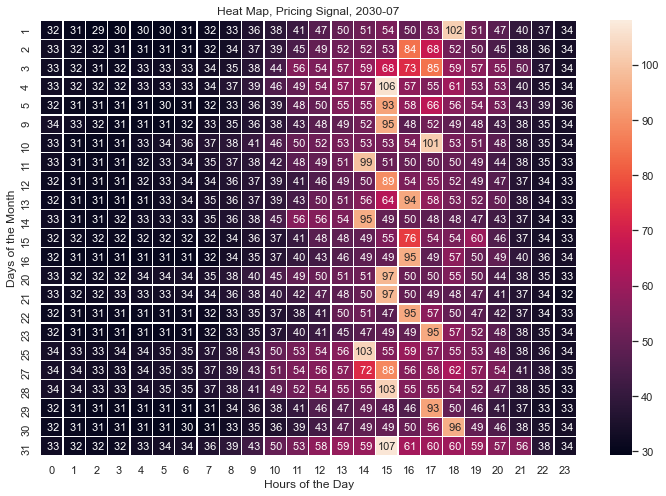

In [17]:
dfp_piv = dfp.pivot('day', 'hour', 'total_price')

fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(dfp_piv, annot=True, vmax = 108, annot_kws={"size": 11}, fmt='3.0f', linewidths=.3)
ax.set_title('Heat Map, Pricing Signal, 2030-07')
ax.set_ylabel("Days of the Month")
ax.set_xlabel("Hours of the Day")

# Save the figure
fig.savefig('July/heatmap_p.pdf', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format='pdf',
        transparent=False, bbox_inches='tight', pad_inches=0.05,
        frameon=None, metadata=None)

C:\Users\maxan\anaconda3\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  del sys.path[0]
C:\Users\maxan\anaconda3\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  del sys.path[0]


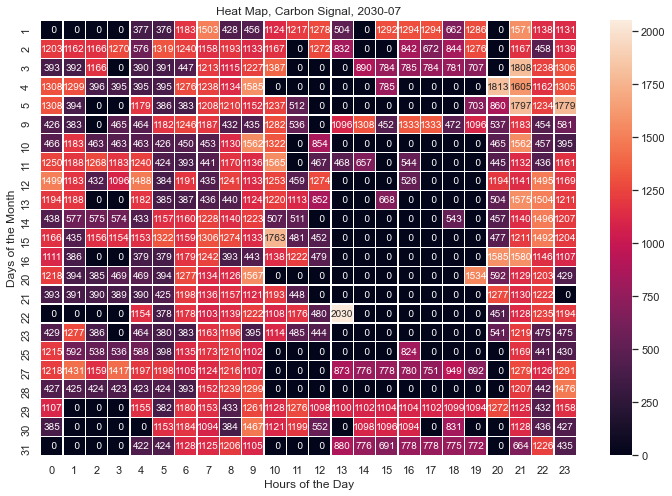

In [18]:
dfc_piv = dfc.pivot('day', 'hour', 'co2_rate_marginal')

fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(dfc_piv, vmax = 2050, annot=True, annot_kws={"size": 10}, fmt='3.0f', linewidths=.3)
ax.set_title('Heat Map, Carbon Signal, 2030-07')
ax.set_ylabel("Days of the Month")
ax.set_xlabel("Hours of the Day")

# Save the figure
fig.savefig('July/heatmap_c.pdf', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format='pdf',
        transparent=False, bbox_inches='tight', pad_inches=0.05,
        frameon=None, metadata=None)

C:\Users\maxan\anaconda3\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  
C:\Users\maxan\anaconda3\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  


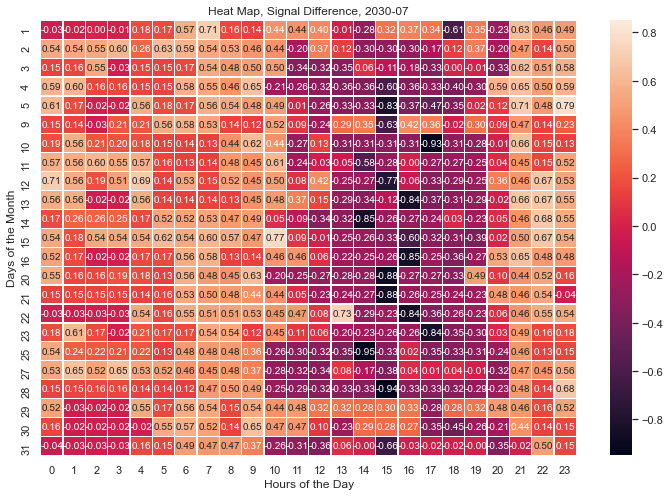

In [19]:
dff_piv = pd.pivot_table(df, values='Abs', index=['day'], columns='hour')
# dff_piv = dff.pivot('day', 'hour', 'co2_rate_marginal')

fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(dff_piv, vmax = 0.85, annot=True, annot_kws={"size": 10}, fmt='0.2f', linewidths=.3)
ax.set_title('Heat Map, Signal Difference, 2030-07')
ax.set_ylabel("Days of the Month")
ax.set_xlabel("Hours of the Day")

# Save the figure
fig.savefig('July/heatmap_f.pdf', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format='pdf',
        transparent=False, bbox_inches='tight', pad_inches=0.05,
        frameon=None, metadata=None)

# K-Medoids Evaluation

C:\Users\maxan\anaconda3\lib\site-packages\ipykernel_launcher.py:44: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
C:\Users\maxan\anaconda3\lib\site-packages\ipykernel_launcher.py:44: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later


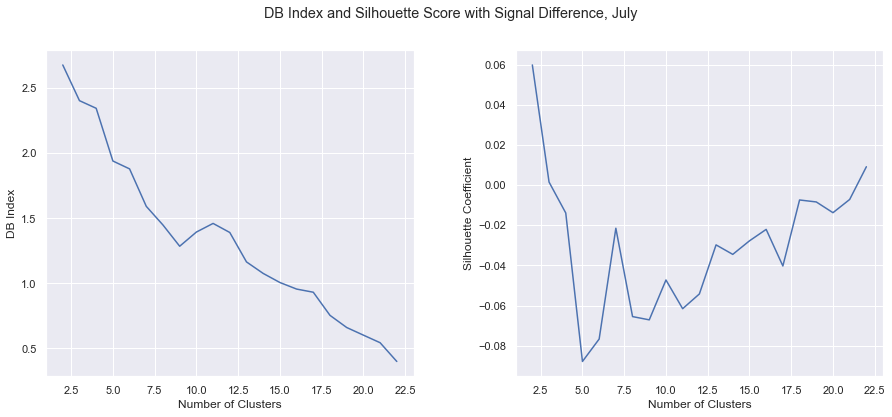

In [79]:
# a = np.load("listDBidx_med.npz")
# dbidx = a['arr_0']

# b = np.load("listSil_med.npz")
# sil = b['arr_0']

clusterlist = range(2, 23, 1)

dbidx = []
sil = []


for n_clusters in clusterlist:
    kmedoids = KMedoids(n_clusters=n_clusters, random_state = 3)
    kmedoids.fit(df_p)                                                              # here
    labels = kmedoids.labels_
    DB = davies_bouldin_score(df_diff,labels)                                       # here
    silCof = silhouette_score(df_diff, labels, metric='euclidean')                  # here
    dbidx.append(DB)
    sil.append(silCof)

np.savez("July/listDBidx_med", dbidx)                                               # here
np.savez("July/listSil_med", sil)                                                   # here

fig = plt.figure(figsize=(15,6))
fig.suptitle('DB Index and Silhouette Score with Signal Difference, July')          # here
gs = gridspec.GridSpec(1, 3, width_ratios=[1,0.01,1])

# fig, (ax1, ax2) = plt.subplots(1, 2)
ax1 = plt.subplot(gs[0])
ax1.plot(clusterlist, dbidx, label = "DB Index")
ax1.set_ylabel("DB Index")
ax1.set_xlabel("Number of Clusters")

ax2 = plt.subplot(gs[2])
ax2.plot(clusterlist, sil, label = "Silhouette Coefficient")
ax2.set_ylabel("Silhouette Coefficient")
ax2.set_xlabel("Number of Clusters")

# Save the figure
fig.savefig('July/eval_kmedoids.pdf', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format='pdf',
        transparent=False, bbox_inches='tight', pad_inches=0.05,
        frameon=None, metadata=None)                                                # here

# DBSCAN Parametric

In [91]:
# a = np.load("listepstempDBSCAN.npz")
# epstemp = a['arr_0']

# b = np.load("listsampDBSCAN.npz")
# samp = b['arr_0']

# c = np.load("listnclusterDBSCAN.npz")
# n_cluster = c['arr_0']

# d = np.load("listnnoiseDBSCAN.npz")
# n_noise = d['arr_0']


eps_list = np.linspace(0.2,1.2,20)
samples_list = np.linspace(1, 23, 22)

dbidx = []
sil = []
n_cluster = []
n_noise = []
epstemp = []
samp = []


for eps in eps_list:
    for samples in samples_list:
        dbscan = DBSCAN(eps=eps, min_samples=samples)
        clusters = dbscan.fit_predict(df_p)                                 # here
        core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
        core_samples_mask[dbscan.core_sample_indices_] = True
        labels = dbscan.labels_
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)
        
        epstemp.append(eps)
        samp.append(samples)
        n_cluster.append(n_clusters_)
        n_noise.append(n_noise_)

np.savez("July/listepstempDBSCAN", epstemp)
np.savez("July/listsampDBSCAN", samp)
np.savez("July/listnclusterDBSCAN", n_cluster)
np.savez("July/listnnoiseDBSCAN", n_noise)

C:\Users\maxan\anaconda3\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
C:\Users\maxan\anaconda3\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later


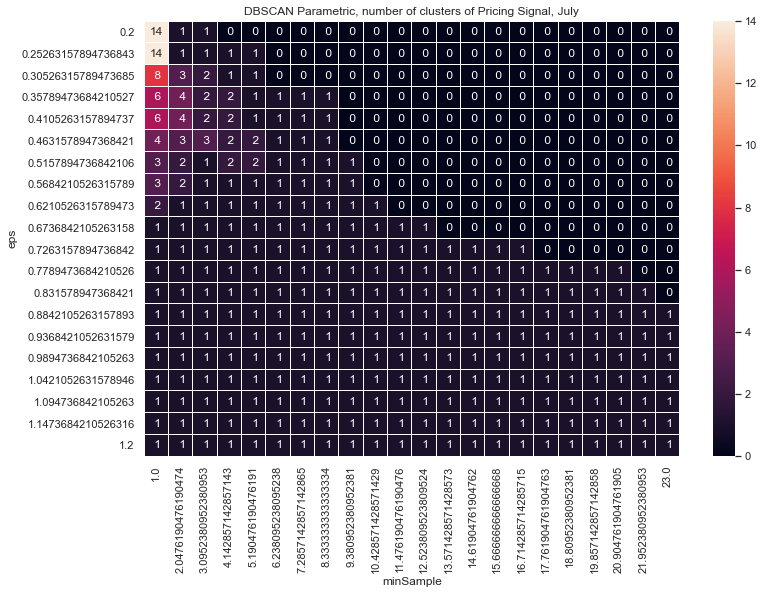

In [92]:
DBcombo1 = pd.DataFrame(list(zip(epstemp, samp, n_cluster)), 
               columns =['eps', 'minSample', 'n_cluster'])
DBcombo1_piv = DBcombo1.pivot('eps', 'minSample', 'n_cluster')
DBcombo1_piv = DBcombo1_piv.round(decimals=2)

class ScalarFormatterForceFormat(ScalarFormatter):
    def _set_format(self):  # Override function that finds format to use.
        self.format = "%4.0f"  # Give format here

yfmt = ScalarFormatterForceFormat()
yfmt.set_powerlimits((0,0))

f, ax = plt.subplots(figsize=(12, 8))
DBSCANfig = sns.heatmap(DBcombo1_piv, annot=True, fmt = '2.0f', linewidths=.02, ax=ax)
ax.set_title('DBSCAN Parametric, number of clusters of Pricing Signal, July')         # here
# ax.yaxis.set_major_formatter(yfmt)
# ax.xaxis.set_major_formatter(yfmt)

# Save the figure
f.savefig('July/eval_DBSCANp.pdf', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format='pdf',
        transparent=False, bbox_inches='tight', pad_inches=0.05,
        frameon=None, metadata=None)                                                     # here

C:\Users\maxan\anaconda3\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
C:\Users\maxan\anaconda3\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later


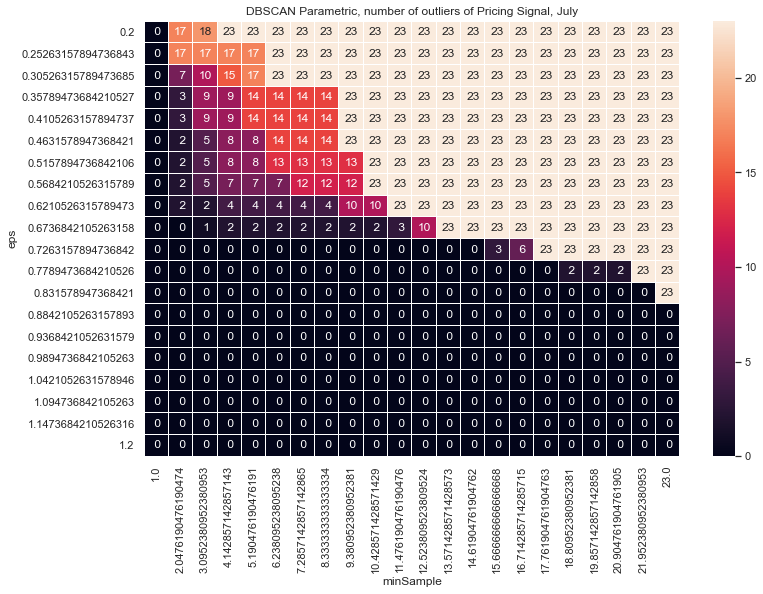

In [93]:
DBcombo2 = pd.DataFrame(list(zip(epstemp, samp, n_noise)), 
               columns =['eps', 'minSample', 'n_noise'])
DBcombo2_piv = DBcombo2.pivot('eps', 'minSample', 'n_noise')
DBcombo2_piv = DBcombo2_piv.round(decimals=2)

class ScalarFormatterForceFormat(ScalarFormatter):
    def _set_format(self):  # Override function that finds format to use.
        self.format = "%4.0f"  # Give format here

yfmt = ScalarFormatterForceFormat()
yfmt.set_powerlimits((0,0))

f, ax = plt.subplots(figsize=(12, 8))
DBSCANfig = sns.heatmap(DBcombo2_piv, annot=True, fmt = '2.0f', linewidths=.02, ax=ax)
ax.set_title('DBSCAN Parametric, number of outliers of Pricing Signal, July')                    # here 
# ax.yaxis.set_major_formatter(yfmt)
# ax.xaxis.set_major_formatter(yfmt)

# Save the figure
f.savefig('July/eval_DBSCANp2.pdf', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format='pdf',
        transparent=False, bbox_inches='tight', pad_inches=0.05,
        frameon=None, metadata=None)                                                                # here

0.4499789120947532
0.5268421688311505


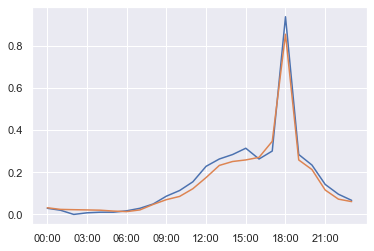

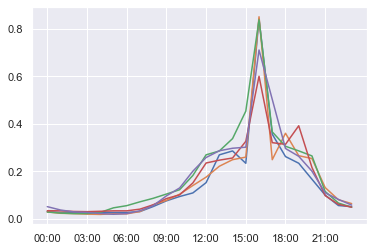

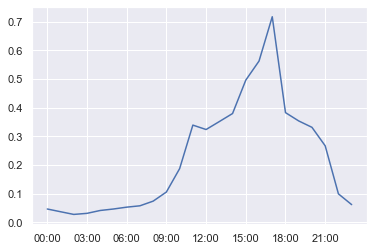

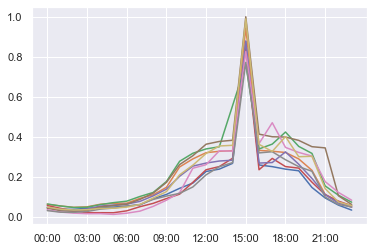

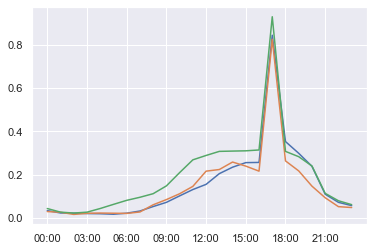

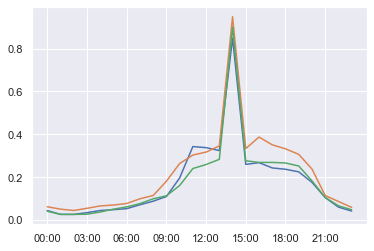

In [92]:
eps = 0.41 # here
samples = 1

dbscan = DBSCAN(eps=eps, min_samples=samples)
clusters = dbscan.fit_predict(df_p)                                 # here
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
labels = dbscan.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
DB = davies_bouldin_score(df_p,labels)                                       # here
print(DB)
silCof = silhouette_score(df_p, labels, metric='euclidean')                  # here
print(silCof)
clustertemp = pd.DataFrame(labels,columns=['ClusterNo'])

temp = pd.concat([df_p.dropna().reset_index(), clustertemp], axis=1)      # here
temp2 = temp.drop(['Dates'],axis=1)
cluster = temp2.set_index(['ClusterNo']).sort_index()

for i in range(0,n_clusters_,1):
    vistemp = cluster.loc[i].T
    fig, ax = plt.subplots(figsize=(6, 4))
    vistemp.plot(ax=ax, legend=False, alpha=1,xticks=np.arange(0, 86400, 10800))
    ax.set_xlabel(None)

# Agglomerative Clustering (ward) - scikit learn 

Text(0, 0.5, 'Cluster distance')

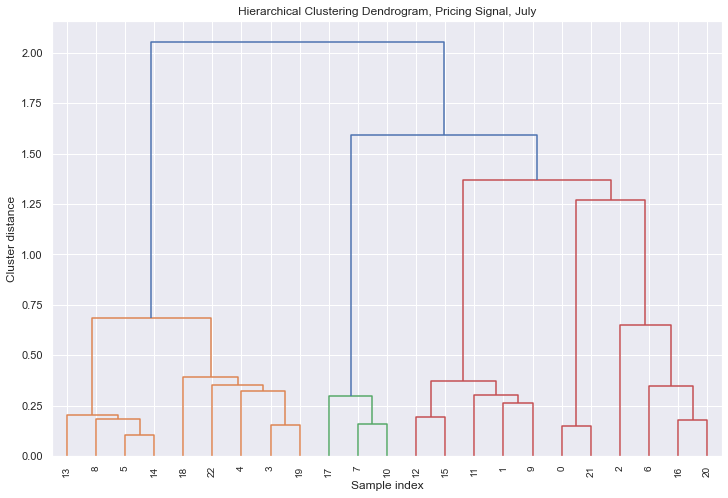

In [20]:
linkage_array = ward(df_p)                                                          # here

# mark the cuts in the tree that signify two or three clusters
f, ax = plt.subplots(figsize=(12, 8))
dendrogram(linkage_array, leaf_rotation=90.)
# bounds = ax.get_xbound()
# ax.plot(bounds, [7.25, 7.25], '--', c='k')
# ax.plot(bounds, [4, 4], '--', c='k')

# ax.text(bounds[1], 7.25, ' two clusters', va='center', fontdict={'size': 15})
# ax.text(bounds[1], 4, ' three clusters', va='center', fontdict={'size': 15})
plt.title('Hierarchical Clustering Dendrogram, Pricing Signal, July')                              # here
plt.xlabel("Sample index")
plt.ylabel("Cluster distance")

# # Save the figure
# f.savefig('July/eval_hierdenp.pdf', dpi=None, facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format='pdf',
#         transparent=False, bbox_inches='tight', pad_inches=0.05,
#         frameon=None, metadata=None)                                                                  # here

Text(0.5, 0, 'Number of Clusters')

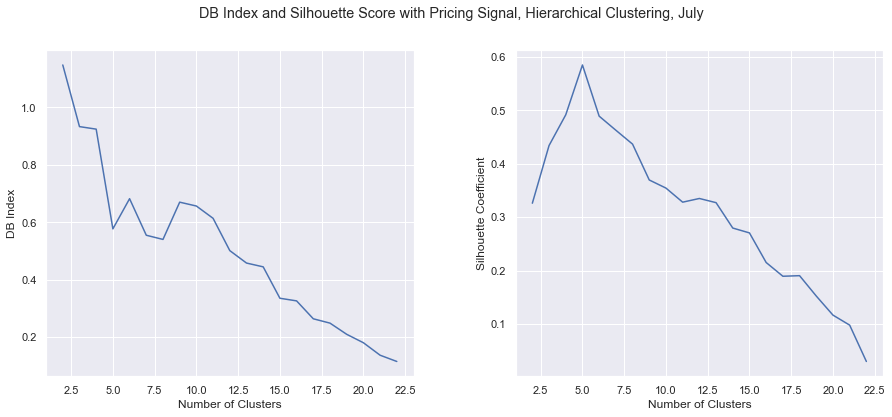

In [22]:
# a = np.load("listDBidx_hier.npz")
# dbidx = a['arr_0']

# b = np.load("listSil_hier.npz")
# sil = b['arr_0']

clusterlist = range(2, 23, 1)

dbidx = []
sil = []


for n_clusters in clusterlist:
    cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
    cluster.fit_predict(df_p)                                                                          # here
    labels = cluster.labels_
    DB = davies_bouldin_score(df_p,labels)                                                             # here
    silCof = silhouette_score(df_p, labels, metric='euclidean')                                        # here
    dbidx.append(DB)
    sil.append(silCof)

np.savez("July/listDBidx_hier", dbidx)
np.savez("July/listSil_hier", sil)

fig = plt.figure(figsize=(15,6))
fig.suptitle('DB Index and Silhouette Score with Pricing Signal, Hierarchical Clustering, July')             # here
gs = gridspec.GridSpec(1, 3, width_ratios=[1,0.01,1])

# fig, (ax1, ax2) = plt.subplots(1, 2)
ax1 = plt.subplot(gs[0])
ax1.plot(clusterlist, dbidx, label = "DB Index")
ax1.set_ylabel("DB Index")
ax1.set_xlabel("Number of Clusters")

ax2 = plt.subplot(gs[2])
ax2.plot(clusterlist, sil, label = "Silhouette Coefficient")
ax2.set_ylabel("Silhouette Coefficient")
ax2.set_xlabel("Number of Clusters")

# # Save the figure
# fig.savefig('July/eval_hier.pdf', dpi=None, facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format='pdf',
#         transparent=False, bbox_inches='tight', pad_inches=0.05,
#         frameon=None, metadata=None)                                                                  # here

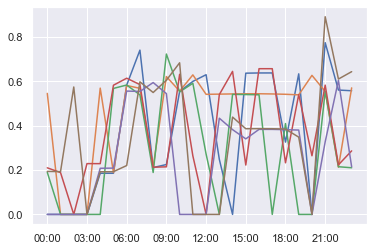

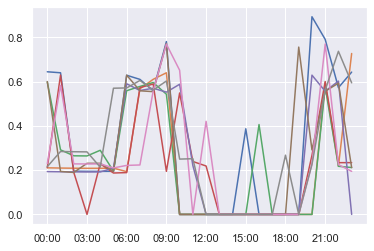

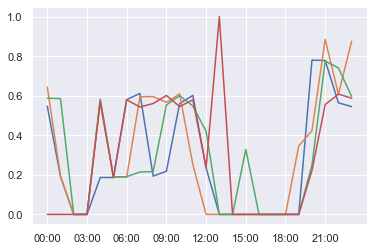

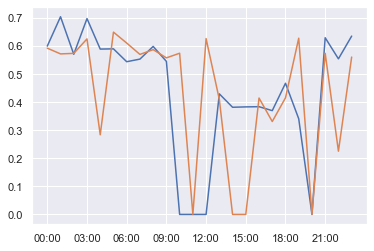

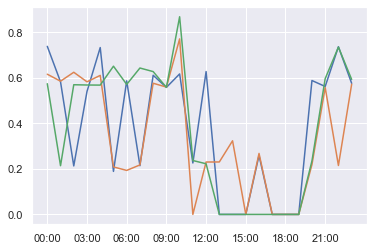

In [93]:
n = 5                                              # here
cluster = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
cluster.fit_predict(df_c)                                                                          # here
labels = cluster.labels_
clustertemp = pd.DataFrame(labels,columns=['ClusterNo'])

temp = pd.concat([df_c.dropna().reset_index(), clustertemp], axis=1)      # here
temp2 = temp.drop(['Dates'],axis=1)
cluster = temp2.set_index(['ClusterNo']).sort_index()

for i in range(0,n,1):
    vistemp = cluster.loc[i].T
    fig, ax = plt.subplots(figsize=(6, 4))
    vistemp.plot(ax=ax, legend=False, alpha=1,xticks=np.arange(0, 86400, 10800))
    ax.set_xlabel(None)

In [118]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

# model = model.fit(df_p)
# plt.title('Hierarchical Clustering Dendrogram')
# # plot the top three levels of the dendrogram
# plot_dendrogram(model, truncate_mode='level', p=5)
# plt.xlabel("Number of points in node")
# plt.show()

# K-Means old code

In [6]:
# Apply K-means with selected n_cluster
kmeans = KMeans(n_clusters=10)
kmeans.fit(df_diff)
labels = kmeans.labels_
clustertemp = pd.DataFrame(labels,columns=['ClusterNo'])

temp = pd.concat([df_diff.dropna().reset_index(), clustertemp], axis=1) 
temp2 = temp.drop(['Dates'],axis=1)
cluster = temp2.set_index(['ClusterNo']).sort_index().T

list1 = list(cluster.columns.get_level_values(0).unique())
for col in list1:
    days = cluster[col].shape
    print("Number of days in cluster {} is: {}".format(col, days))

Number of days in cluster 0 is: (24, 37)
Number of days in cluster 1 is: (24, 34)
Number of days in cluster 2 is: (24, 15)
Number of days in cluster 3 is: (24, 49)
Number of days in cluster 4 is: (24, 56)
Number of days in cluster 5 is: (24, 39)
Number of days in cluster 6 is: (24, 32)
Number of days in cluster 7 is: (24, 26)
Number of days in cluster 8 is: (24, 45)
Number of days in cluster 9 is: (24, 22)


C:\Users\maxan\anaconda3\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  del sys.path[0]
C:\Users\maxan\anaconda3\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  del sys.path[0]


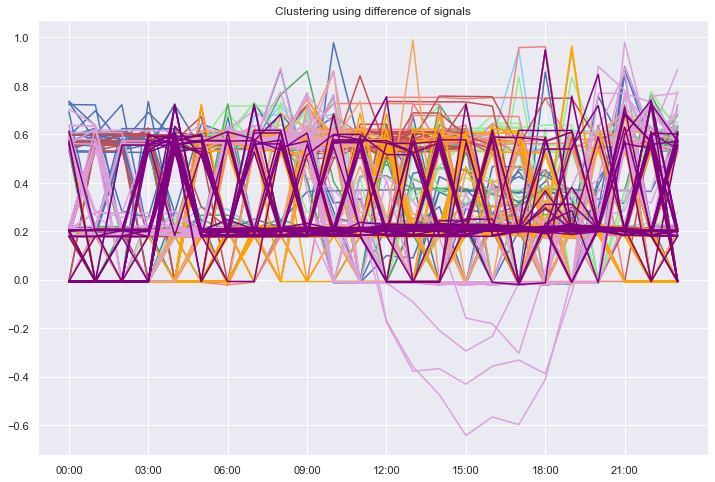

In [34]:
styles2 = ['LightSkyBlue', 'b','LightGreen','g','LightCoral','r','SandyBrown','Orange','Plum','Purple','Gold','b']
fig, axs = plt.subplots(figsize=(12,8))

for col, style in zip(list1, styles2):
    cluster[col].plot(ax=axs, style = style, legend=False, alpha=1,xticks=np.arange(0, 86400, 10800))
axs.set_xlabel(None)
axs.set_title("Clustering using difference of signals")
    
# Save the figure
fig.savefig('abs.pdf', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format='pdf',
        transparent=False, bbox_inches='tight', pad_inches=0.05,
        frameon=None, metadata=None)

C:\Users\maxan\anaconda3\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
C:\Users\maxan\anaconda3\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later


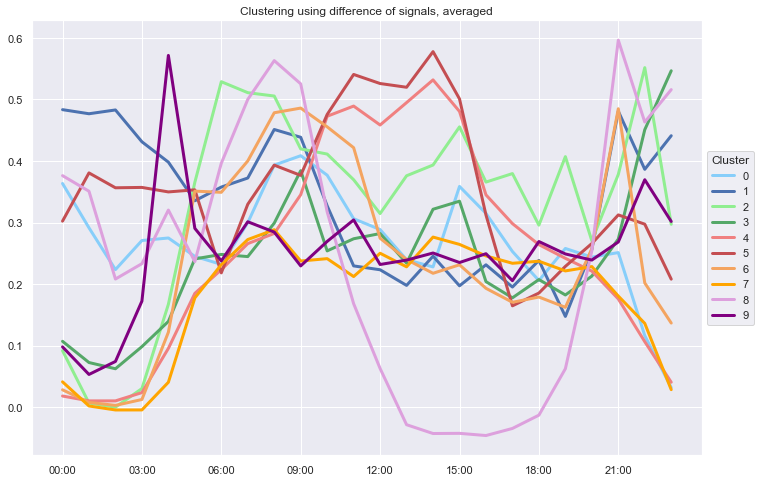

In [35]:
fig, axs = plt.subplots(figsize=(12,8))

# Create a new result dataframe with the mean value of each cluster
avgtemp = temp
cluster_avg = avgtemp.groupby('ClusterNo').mean()
cluster_avg = pd.DataFrame(cluster_avg.reset_index())
cluster_avg = cluster_avg.set_index('ClusterNo')

# Print the averaged result dataframe
styles2 = ['LightSkyBlue', 'b','LightGreen','g','LightCoral','r','SandyBrown','Orange','Plum','Purple','Gold','b']
axs = cluster_avg.T.plot(ax=axs, linewidth=3, style=styles2, xticks=np.arange(0, 86400, 10800))
axs.set_xlabel(None)
axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Cluster')
axs.set_title("Clustering using difference of signals, averaged")

# Save the figure
fig = axs.get_figure()
fig.savefig('abs_avg.pdf', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format='pdf',
        transparent=False, bbox_inches='tight', pad_inches=0.05,
        frameon=None, metadata=None)

In [36]:
# Apply K-means with selected n_cluster
kmeans = KMeans(n_clusters=15)
kmeans.fit(df_p)
labels = kmeans.labels_
clustertemp = pd.DataFrame(labels,columns=['ClusterNo'])

temp = pd.concat([df_p.dropna().reset_index(), clustertemp], axis=1) 
temp2 = temp.drop(['Dates'],axis=1)
cluster = temp2.set_index(['ClusterNo']).sort_index().T
list1 = list(cluster.columns.get_level_values(0).unique())
for col in list1:
    days = cluster[col].shape
    print("Number of days in cluster {} is: {}".format(col, days))

Number of days in cluster 0 is: (24, 118)
Number of days in cluster 1 is: (24,)
Number of days in cluster 2 is: (24,)
Number of days in cluster 3 is: (24,)
Number of days in cluster 4 is: (24,)
Number of days in cluster 5 is: (24,)
Number of days in cluster 6 is: (24, 96)
Number of days in cluster 7 is: (24,)
Number of days in cluster 8 is: (24,)
Number of days in cluster 9 is: (24, 53)
Number of days in cluster 10 is: (24, 17)
Number of days in cluster 11 is: (24, 45)
Number of days in cluster 12 is: (24, 26)
Number of days in cluster 13 is: (24,)
Number of days in cluster 14 is: (24, 2)


Text(0.5, 1.0, 'Clustering of pricing signal')

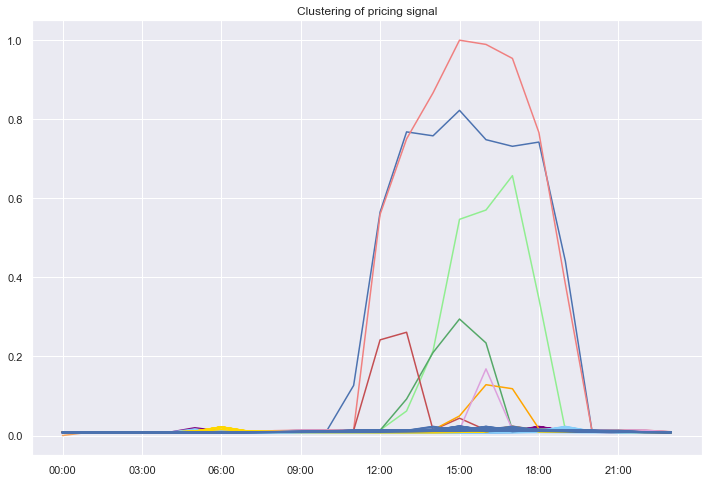

In [37]:
styles2 = ['Purple', 'b','LightGreen','g','LightCoral','r','SandyBrown','Orange','Plum','LightSkyBlue','Gold','b']
fig, axs = plt.subplots(figsize=(12,8))


for col, style in zip(list1, styles2):
    cluster[col].plot(ax=axs, style = style, legend=False, alpha=1,xticks=np.arange(0, 86400, 10800))
axs.set_xlabel(None)
axs.set_title("Clustering of pricing signal")
    
# # Save the figure
# fig.savefig('K-means_original.pdf', dpi=None, facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format='pdf',
#         transparent=False, bbox_inches='tight', pad_inches=0.05,
#         frameon=None, metadata=None)

Text(0.5, 1.0, 'Clustering of pricing signal, averaged')

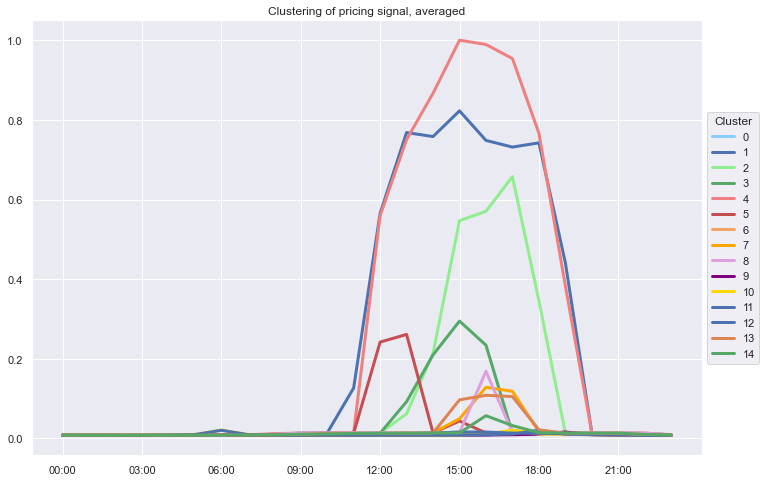

In [38]:
fig, axs = plt.subplots(figsize=(12,8))

# Create a new result dataframe with the mean value of each cluster
avgtemp = temp
cluster_avg = avgtemp.groupby('ClusterNo').mean()
cluster_avg = pd.DataFrame(cluster_avg.reset_index())
cluster_avg = cluster_avg.set_index('ClusterNo')

# Print the averaged result dataframe
styles2 = ['LightSkyBlue', 'b','LightGreen','g','LightCoral','r','SandyBrown','Orange','Plum','Purple','Gold','b']
axs = cluster_avg.T.plot(ax=axs, linewidth=3, style=styles2, xticks=np.arange(0, 86400, 10800))
axs.set_xlabel(None)
axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Cluster')
axs.set_title("Clustering of pricing signal, averaged")

# Save the figure
# fig = ax.get_figure()
# fig.savefig('K-means_average.pdf', dpi=None, facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format='pdf',
#         transparent=False, bbox_inches='tight', pad_inches=0.05,
#         frameon=None, metadata=None)

In [39]:
# Apply K-means with selected n_cluster
kmeans = KMeans(n_clusters=3, random_state = 3)
kmeans.fit(df_c)
labels = kmeans.labels_
clustertemp = pd.DataFrame(labels,columns=['ClusterNo'])

temp = pd.concat([df_c.dropna().reset_index(), clustertemp], axis=1) 
temp2 = temp.drop(['Dates'],axis=1)
cluster = temp2.set_index(['ClusterNo']).sort_index().T
list1 = list(cluster.columns.get_level_values(0).unique())
for col in list1:
    days = cluster[col].shape[1]
    print("Number of days in cluster {} is: {}".format(col, days))

Number of days in cluster 0 is: 154
Number of days in cluster 1 is: 103
Number of days in cluster 2 is: 108


C:\Users\maxan\anaconda3\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  
C:\Users\maxan\anaconda3\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  


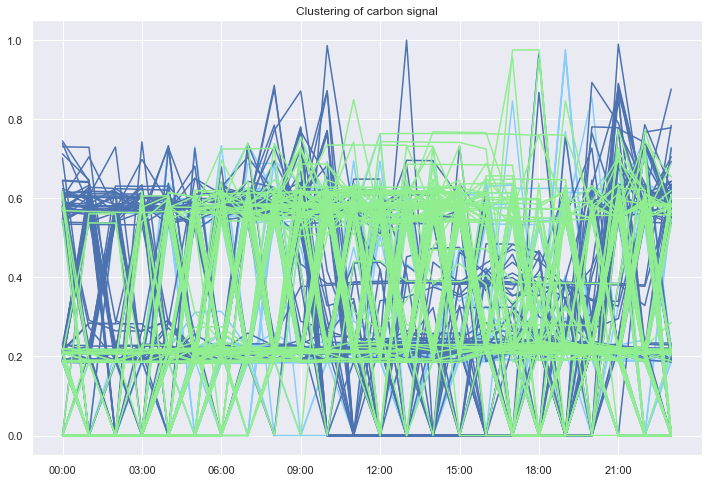

In [40]:
styles2 = ['LightSkyBlue', 'b','LightGreen','g','LightCoral','r','SandyBrown','Orange','Plum','Purple','Gold','b']
fig, axs = plt.subplots(figsize=(12,8))


for col, style in zip(list1, styles2):
    cluster[col].plot(ax=axs, style = style, legend=False, alpha=1,xticks=np.arange(0, 86400, 10800))
axs.set_xlabel(None)
axs.set_title("Clustering of carbon signal")
    
# Save the figure
fig.savefig('carbon.pdf', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format='pdf',
        transparent=False, bbox_inches='tight', pad_inches=0.05,
        frameon=None, metadata=None)

C:\Users\maxan\anaconda3\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
C:\Users\maxan\anaconda3\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later


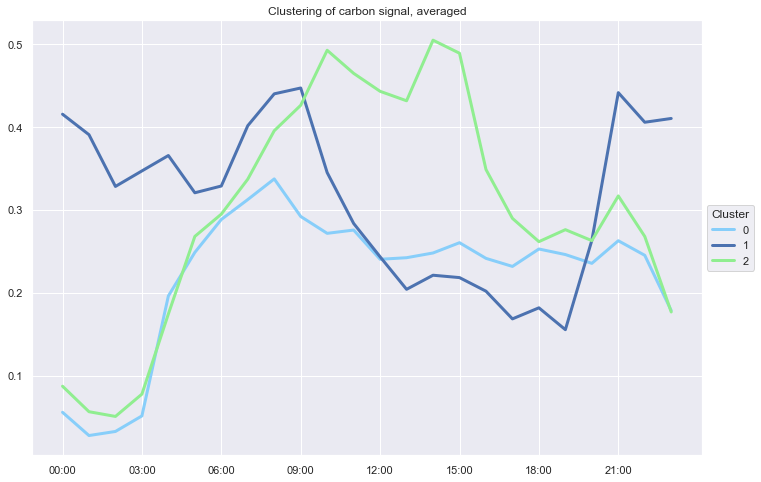

In [41]:
fig, axs = plt.subplots(figsize=(12,8))

# Create a new result dataframe with the mean value of each cluster
avgtemp = temp
cluster_avg = avgtemp.groupby('ClusterNo').mean()
cluster_avg = pd.DataFrame(cluster_avg.reset_index())
cluster_avg = cluster_avg.set_index('ClusterNo')

# Print the averaged result dataframe
styles2 = ['LightSkyBlue', 'b','LightGreen','g','LightCoral','r','SandyBrown','Orange','Plum','Purple','Gold','b']
axs = cluster_avg.T.plot(ax=axs, linewidth=3, style=styles2, xticks=np.arange(0, 86400, 10800))
axs.set_xlabel(None)
axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Cluster')
axs.set_title("Clustering of carbon signal, averaged")

# Save the figure
fig = axs.get_figure()
fig.savefig('carbon_avg.pdf', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format='pdf',
        transparent=False, bbox_inches='tight', pad_inches=0.05,
        frameon=None, metadata=None)